In [5]:
from typing import Tuple, List

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, recall_score, precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
from tensorflow import keras

from constants import TRAINING_PARTITIONS, ALL_PARTITIONS, annotation_mapping, amino_acid_mapping, reverse_annotation_mapping
from constants import TYPES, KINGDOMS, METRIC_KINGDOMS, METRIC_TYPES
from metrics.metrics import *
from utils.Dataset import Dataset
from utils.helpers import getDatasetPath
from utils.encoding import categoricalToSequence, oneHotToCategorical, sequenceToCategorical, categoricalToOneHot
from serialization import Serializer

# Load model & data

In [6]:
run_timestamp = "20211113-1438"
base_path = f"../results/{run_timestamp}/"
final_model = keras.models.load_model(base_path + f"models/final_model.h5")

test_data = Dataset(getDatasetPath()).getFolds([0])

# Make predictions

In [83]:
test_x = np.array([categoricalToOneHot(sequenceToCategorical(seq, amino_acid_mapping), amino_acid_mapping) for seq in test_data["sequence"]])
predictions = final_model.predict(test_x)
y_true = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in test_data["annotation"]])
y_pred = np.array([oneHotToCategorical(pred) for pred in predictions])

# Convert predictions to per-protein ones

In [92]:
def convertToPerProteinPrediction(prediction: str) -> str:
    if sum([prediction.count(label) for label in "STL"]) > 5:
        type_number = np.argmax([prediction.count('S'), prediction.count('T'), prediction.count('L')])
    else:
        type_number = 3

    return {0: "SP", 1: "TAT", 2: "LIPO", 3: "NO_SP"}[type_number]

test_data["prediction"] = np.array([convertToPerProteinPrediction(categoricalToSequence(pred, reverse_annotation_mapping)) for pred in y_pred])
test_data["label"] = list(test_data.index.get_level_values("type"))

In [91]:
test_data[test_data["prediction"] != test_data["label"]]

sequence  \
partition type kingdom  number                                                      
0         TAT  POSITIVE 10      MHKRRRLLAFATVGAVICTAGFTPSVSQAASSGDGEEKGSYAETHG...   
                        12      MRNRGFGRRELLVAMAMLVSVTGCARHASGARPASTTLPAGADLAD...   
                        15      MRRPVSRRAIFATSVLVAGVSIMSPSANAAEAPASEWVNTTAIVDQ...   
          SP   EUKARYA  13      MKVLIIFACLVVMASAVCNRLEQILVKTQWAQSYGEAENRAAFSRD...   
                        30      MKHPLCTLLSLITFMCIGSKGLAEQLTNENLTTSFLPANFHKENTV...   
...                                                                           ...   
          LIPO NEGATIVE 163     MKIKKIKLLKALALTGAFGIVATVPVIVYSCSSTDNNGGTGDNNTG...   
                        174     MLGRSLTSVLIVPTGIGCAVGGYAGDALPLARAIASVSDRLITHPN...   
                        196     MKRVSQMTALAMALGLACASSWAAELAKPLTLDQLQQQNGKAIDTR...   
                        197     MKALSPIAVLISALLLQGCVAAAVVGTAAVGTKAATDPRSVGTQVD...   
                        202     MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...   

                                                                       annotation  \
partition type kingdom  number                                                      
0         TAT  POSITIVE 10      TTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOO...   
                        12      TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOO...   
                        15      TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOO...   
          SP   EUKARYA  13      SSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        30      SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOO...   
...                                                                           ...   
          LIPO NEGATIVE 163     LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOO...   
                        174     LLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        196     LLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        197     LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        202     LLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOO...   

                               prediction label  
partition type kingdom  number                   
0         TAT  POSITIVE 10             SP   TAT  
                        12           LIPO   TAT  
                        15             SP   TAT  
          SP   EUKARYA  13           LIPO    SP  
                        30           LIPO    SP  
...                                   ...   ...  
          LIPO NEGATIVE 163            SP  LIPO  
                        174            SP  LIPO  
                        196            SP  LIPO  
                        197            SP  LIPO  
                        202            SP  LIPO  

[119 rows x 4 columns]

In [53]:
test_data

sequence  \
partition type kingdom  number                                                      
0         TAT  ARCHAEA  0       MSKDRDGRRTSRRGTLKKIGGFSLGALSFGAVGRTQAATGSSVTTA...   
                        1       MNRPRITGSKQASRRTVLKGIGVLGAAVFGTAASVGSSAAVGDSAV...   
                        2       MPSRRDVLRLGAGVLAAGTAGCTDTAPNRVAAAETAATTTRETTTD...   
                        3       MKRREFLRTAGGATAAATAAAGTAAAQEGGGGAQVQPDFGGYLDGV...   
                        4       MTDGNVDMSRRAFLGAAAGGAAVAATSGTAAAQTEEPDFGGHLDGI...   
...                                                                           ...   
          LIPO NEGATIVE 202     MKVKYALLSAGALQLLVVGCGSSHHETHYGYATLSYADYWAGELGQ...   
                        203     MKLKATLTLAAATLVLAACDQSSSANKSTAQTEAKSSSNNTFVYCT...   
                        204     MKLKTLALSLLAAGVLAGCSSHSSNMANTQMKSDKIIIAHRGASGY...   
                        205     MKRFWAMVCALFLSVSLLLTSCANVPTGLTGNFREDTLALISSLRE...   
                        206     MNRTNQLILGAVVLGSTLLAGCSSNAKIDQLSSDVQTLSAKVEQLS...   

                                                                       annotation  \
partition type kingdom  number                                                      
0         TAT  ARCHAEA  0       TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...   
                        1       TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOO...   
                        2       TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOO...   
                        3       TTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOO...   
                        4       TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOO...   
...                                                                           ...   
          LIPO NEGATIVE 202     LLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        203     LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        204     LLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        205     LLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOO...   
                        206     LLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOO...   

                               prediction label  
partition type kingdom  number                   
0         TAT  ARCHAEA  0             TAT   TAT  
                        1             TAT   TAT  
                        2             TAT   TAT  
                        3             TAT   TAT  
                        4             TAT   TAT  
...                                   ...   ...  
          LIPO NEGATIVE 202            SP  LIPO  
                        203          LIPO  LIPO  
                        204          LIPO  LIPO  
                        205          LIPO  LIPO  
                        206          LIPO  LIPO  

[4104 rows x 4 columns]

# Bootstrap & evaluate

In [108]:
num_bootstraps = 1024
warnings.filterwarnings("ignore")
bootstraps = {i: test_data.sample(frac=1, replace=True, axis=0) for i in range(num_bootstraps)}

In [110]:
def getRelevantData(df: pd.DataFrame, query: str) -> Tuple[np.ndarray, np.ndarray]:
    relevant_data = df.query(query)
    return (list(relevant_data["prediction"]), list(relevant_data["label"]))

In [112]:
metrics = {"mcc": matthews_corrcoef, "precision": precision_score, "recall": recall_score}
final_metrics_dict = {}
for i in tqdm(range(num_bootstraps), desc="Computing metrics"):
    final_metrics_dict[i] = {}
    for metric_name, metric in metrics.items():
        # All sequences
        y_pred, y_true = getRelevantData(bootstraps[i], "index == index")
        if metric_name != "mcc":
            value = metric(y_true, y_pred, average="macro")
        else:
            value = metric(y_true, y_pred)
        final_metrics_dict[i][metric_name] = {
            "overall": {
                "overall": value
            }
        }

        # By kingdom
        for kingdom in KINGDOMS:
            y_pred, y_true = getRelevantData(bootstraps[i], f"kingdom == '{kingdom}'")
            if metric_name != "mcc":
                final_metrics_dict[i][metric_name]["overall"][kingdom] = metric(y_true, y_pred, average="macro")
            else:
                final_metrics_dict[i][metric_name]["overall"][kingdom] = metric(y_true, y_pred)

# Manually exclude non-existing labels (L & T) from eukarya
for i in tqdm(range(num_bootstraps), desc="Excluding non-existent pathways"):
    y_pred, y_true = getRelevantData(bootstraps[i], "kingdom == 'EUKARYA'")
    final_metrics_dict[i]["precision"]["overall"]["EUKARYA"] = precision_score(y_true, y_pred, average="macro", labels=["NO_SP", "SP"])
    final_metrics_dict[i]["recall"]["overall"]["EUKARYA"] = recall_score(y_true, y_pred, average="macro", labels=["NO_SP", "SP"])

Excluding non-existent pathways: 100%|██████████| 1024/1024 [00:16<00:00, 61.01it/s]


In [114]:
def binarize(labels: List[str], label: str) -> np.ndarray:
    array = np.array(labels)
    binarized = array.copy()
    binarized[array == label] = 1
    binarized[array != label] = 0

    return binarized.astype("int")

In [116]:
# By label
for i in tqdm(range(num_bootstraps), desc="Computing metrics by label"):
    for label in ["SP", "NO_SP", "TAT", "LIPO"]:
        y_true, y_pred = getRelevantData(bootstraps[i], f"index == index")
        y_true = binarize(y_true, label)
        y_pred = binarize(y_pred, label)

        final_metrics_dict[i]["mcc"][label] = {"overall": matthews_corrcoef(y_true, y_pred)}
        final_metrics_dict[i]["precision"][label] = {"overall": precision_score(y_true, y_pred)}
        final_metrics_dict[i]["recall"][label] = {"overall": recall_score(y_true, y_pred)}

# By label x kingdom
for i in tqdm(range(num_bootstraps), desc="Computing metrics by label & kingdom"):
    for label in ["SP", "NO_SP", "TAT", "LIPO"]:
        for kingdom in KINGDOMS:
            y_true, y_pred = getRelevantData(bootstraps[i], f"kingdom == '{kingdom}'")
            y_true = binarize(y_true, label)
            y_pred = binarize(y_pred, label)

            final_metrics_dict[i]["mcc"][label][kingdom] = matthews_corrcoef(y_true, y_pred)
            final_metrics_dict[i]["precision"][label][kingdom] = precision_score(y_true, y_pred)
            final_metrics_dict[i]["recall"][label][kingdom] = recall_score(y_true, y_pred)

Computing metrics by label & kingdom: 100%|██████████| 1024/1024 [01:00<00:00, 16.88it/s]


In [117]:
labels = ["NO_SP", "SP", "TAT", "LIPO"]
final_metrics = pd.DataFrame([
    (metric, bootstrap, label, kingdom, final_metrics_dict[bootstrap][metric][label][kingdom])
    for metric in metrics.keys()
    for bootstrap in range(num_bootstraps)
    for label in METRIC_TYPES
    for kingdom in METRIC_KINGDOMS
])

final_metrics.columns = ["metric", "bootstrap", "label", "kingdom", "value"]
final_metrics.set_index(["metric", "bootstrap", "label", "kingdom"])

value
metric bootstrap label   kingdom           
mcc    0         overall EUKARYA   0.930228
                         ARCHAEA   0.968494
                         POSITIVE  0.856489
                         NEGATIVE  0.925832
                         overall   0.938625
...                                     ...
recall 1023      LIPO    EUKARYA   0.000000
                         ARCHAEA   0.833333
                         POSITIVE  0.963855
                         NEGATIVE  0.958549
                         overall   0.894040

[76800 rows x 1 columns]

<AxesSubplot:>

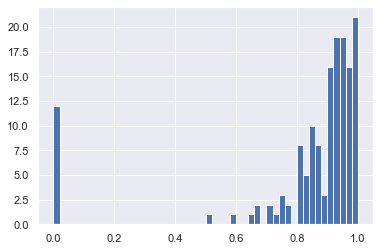

In [105]:
final_metrics["value"].hist(bins=50)

In [104]:
final_metrics.query("metric == 'mcc'")

,metric,bootstrap,label,kingdom,value
0,mcc,0,overall,EUKARYA,0.937731
1,mcc,0,overall,ARCHAEA,0.827396
2,mcc,0,overall,POSITIVE,0.847592
3,mcc,0,overall,NEGATIVE,0.920454
4,mcc,0,overall,overall,0.938732
5,mcc,0,SP,EUKARYA,0.948369
6,mcc,0,SP,ARCHAEA,0.826977
7,mcc,0,SP,POSITIVE,0.656461
8,mcc,0,SP,NEGATIVE,0.845570
9,mcc,0,SP,overall,0.919429


In [34]:
final_metrics.query("kingdom == 'overall'")\
    .groupby(["metric", "label"])\
    .agg(["mean", "std"])\
    ["value"]

mean       std
metric    label                    
mcc       LIPO   0.913881  0.013487
          NO_SP  0.000000  0.000000
          SP     0.092215  0.010593
          TAT    0.904392  0.020700
precision LIPO   0.925207  0.016680
          NO_SP  0.000000  0.000000
          SP     0.964784  0.007379
          TAT    0.967965  0.019248
recall    LIPO   0.915105  0.016949
          NO_SP  0.000000  0.000000
          SP     0.170505  0.005627
          TAT    0.849603  0.033462

In [35]:
final_metrics["ci"] = 1.96 * final_metrics["std"]

KeyError: 'std'

In [41]:
final_metrics\
    .groupby(["kingdom", "metric", "label"])\
    .agg(["mean"], "std")\
    ["value"]

mean
kingdom  metric    label          
ARCHAEA  mcc       LIPO   0.799140
                   NO_SP  0.000000
                   SP     0.239968
                   TAT    0.910638
         precision LIPO   0.834577
                   NO_SP  0.000000
                   SP     0.912973
                   TAT    0.996094
         recall    LIPO   0.824116
                   NO_SP  0.000000
                   SP     0.316475
                   TAT    0.857910
EUKARYA  mcc       LIPO   0.000000
                   NO_SP  0.000000
                   SP    -0.050026
                   TAT    0.000000
         precision LIPO   0.000000
                   NO_SP  0.000000
                   SP     0.983707
                   TAT    0.000000
         recall    LIPO   0.000000
                   NO_SP  0.000000
                   SP     0.146123
                   TAT    0.000000
NEGATIVE mcc       LIPO   0.894921
                   NO_SP  0.000000
                   SP     0.545451
                   TAT    0.991736
         precision LIPO   0.917822
                   NO_SP  0.000000
                   SP     0.931140
                   TAT    1.000000
         recall    LIPO   0.964624
                   NO_SP  0.000000
                   SP     0.482669
                   TAT    0.985983
POSITIVE mcc       LIPO   0.920257
                   NO_SP  0.000000
                   SP     0.417948
                   TAT    0.757534
         precision LIPO   0.950968
                   NO_SP  0.000000
                   SP     0.813876
                   TAT    0.844668
         recall    LIPO   0.963389
                   NO_SP  0.000000
                   SP     0.412808
                   TAT    0.734235
overall  mcc       LIPO   0.913881
                   NO_SP  0.000000
                   SP     0.092215
                   TAT    0.904392
         precision LIPO   0.925207
                   NO_SP  0.000000
                   SP     0.964784
                   TAT    0.967965
         recall    LIPO   0.915105
                   NO_SP  0.000000
                   SP     0.170505
                   TAT    0.849603

# Store results

In [118]:
Serializer.save(final_metrics, "final_metrics_per_protein")